# Dask Delayed - Parallelism

- Delays the execution of tasks.
- Builds a task graph
- Dask scheduler exploits the parallelism from the task graph
- Useful for cases that don't fit with the collections

In [4]:
#!pip install memory_profiler

In [5]:
# Importing dask dataframe
import dask
import dask.delayed as delayed
import time
%load_ext memory_profiler
dask.__version__

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


'2022.02.0'

### Simple Example  

Let us consider the following mathematical steps

Increase the value by one
\begin{align}
 x & = x + 1
\end{align}
Decrease the value by two
\begin{align}
 y & = y - 2
\end{align}
Add two values
\begin{align}
 z & = x + y
\end{align}

#### Task Order
- x and y can be evaluated independently
- z value depends on the evaluation of x and y

In [6]:
# Define simple functions for increament, decrement, and add operations
sleep_time = 1
def inc(x):
    time.sleep(sleep_time)
    return x + 1

def dec(x):
    time.sleep(sleep_time)
    return x - 1

def add(x, y):
    time.sleep(sleep_time)
    return x + y

Serial task executions. Each function takes a second, so executing three functions in sequeence will take three seconds. 

In [7]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
print("computed result ", z)

computed result  3
CPU times: user 20.8 ms, sys: 1.74 ms, total: 22.6 ms
Wall time: 3 s


Now lets build the task-graph with dask.delayed function. 

In [8]:
delayed_inc = delayed(inc)
delayed_dec = delayed(dec)
delayed_add = delayed(add)

In [9]:
x = delayed_inc(1)
y = delayed_dec(2)
z = delayed_add(x, y)
z

Delayed('add-0f5fe177-75f1-4836-b6e5-b79c003ce97f')

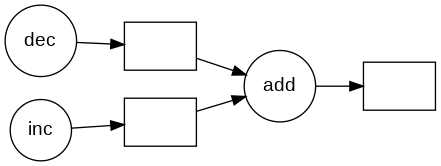

In [10]:
z.visualize(rankdir='LR')

The task-graph shows three tasks. Two of them are independent and they can be executed concurrently. So the total execution time will be two seconds. 

In [11]:
%%time
print("computed result ", z.compute())

computed result  3
CPU times: user 17.8 ms, sys: 6.7 ms, total: 24.5 ms
Wall time: 2.01 s


## Parallelizing a for loop

In [12]:
data = list(range(0,20))

In [13]:
%%time
results = []
for i in data:
    x = inc(i)
    y = dec(i)
    z = add(x, y)
    results.append(z) 
total = sum(results)
print("computed result ", total)

computed result  380
CPU times: user 350 ms, sys: 39.4 ms, total: 389 ms
Wall time: 1min


In [14]:
%%time
results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)  
total = delayed(sum)(results)
print("computed result ", total.compute())

computed result  380
CPU times: user 198 ms, sys: 28.8 ms, total: 227 ms
Wall time: 31.1 s


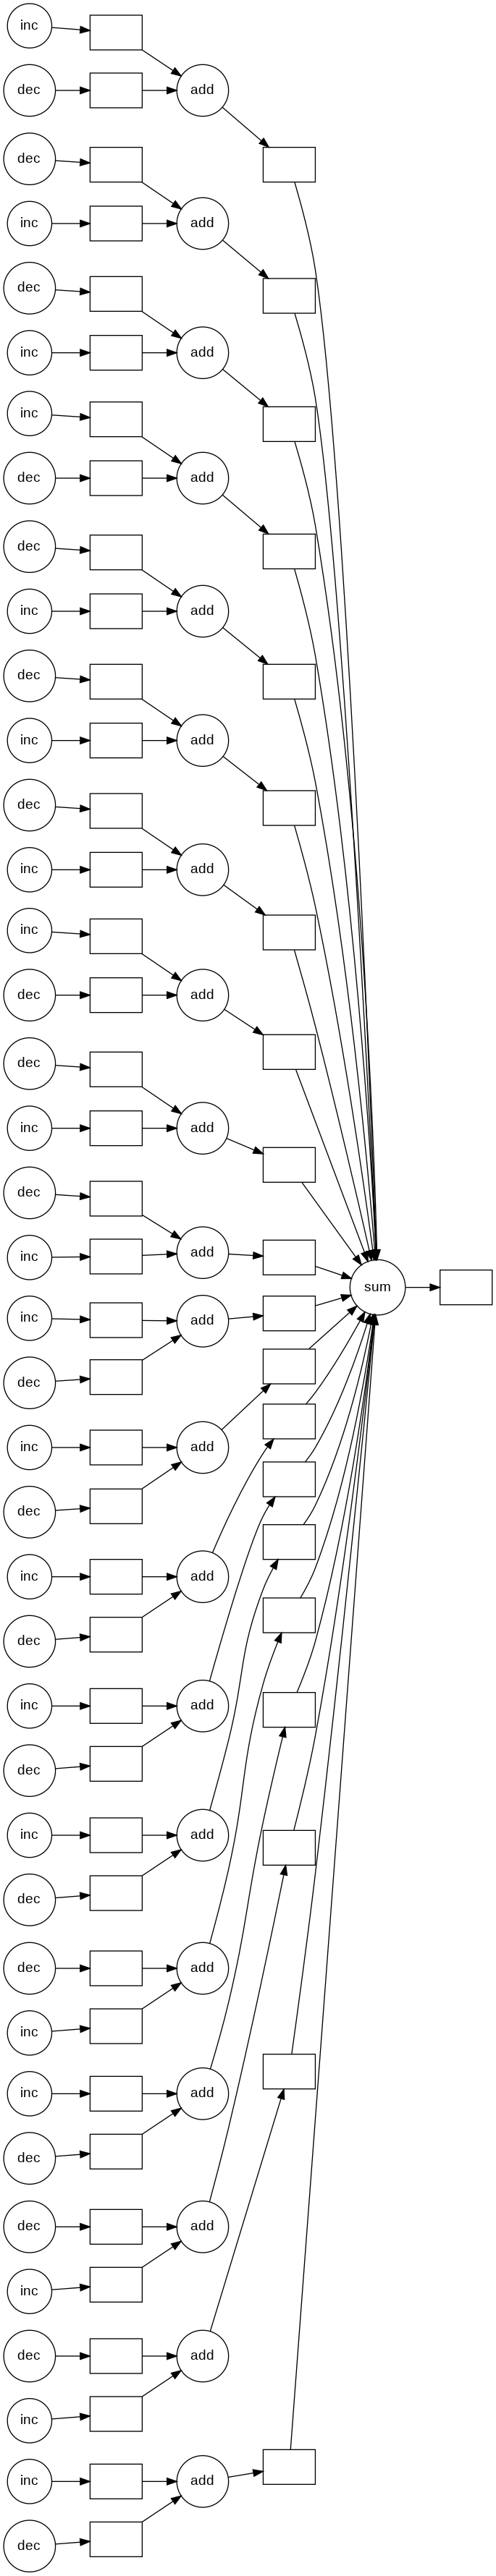

In [15]:
total.visualize(rankdir='LR')

### Dask Scheduler - Threads (Default)

In [16]:
%%time
results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)
    
total = delayed(sum)(results)
print("computed result ", total.compute(scheduler='threads'))

computed result  380
CPU times: user 204 ms, sys: 34.1 ms, total: 238 ms
Wall time: 31.1 s


### Dask Scheduler - Processes

In [17]:
%%time
results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)
    
total = delayed(sum)(results)
print("computed result ", total.compute(scheduler='processes'))

computed result  380
CPU times: user 267 ms, sys: 52.2 ms, total: 319 ms
Wall time: 33.5 s


### Dask Scheduler - single-threaded (for debugging)

In [18]:
%%time

results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)
    
total = delayed(sum)(results)
print("computed result ", total.compute(scheduler='single-threaded'))

computed result  380
CPU times: user 386 ms, sys: 40.9 ms, total: 427 ms
Wall time: 1min


### Dask Distributed Scheduler (For scaling)

In [19]:
from dask.distributed import Client, LocalCluster
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
client 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36461,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:35431,Total threads: 2
Dashboard: http://127.0.0.1:37803/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:33839,


In [20]:
%%time

results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)
    
total = delayed(sum)(results)
print("computed result ", total.compute())

computed result  380
CPU times: user 880 ms, sys: 130 ms, total: 1.01 s
Wall time: 16.2 s


In [21]:
client.shutdown()

In [22]:
from dask.distributed import Client, LocalCluster
client = Client(n_workers=8, threads_per_worker=2, memory_limit='4GB')
client 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36175,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:43961,Total threads: 2
Dashboard: http://127.0.0.1:38011/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:46475,


In [23]:
%%time

results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)
    
total = delayed(sum)(results)
print("computed result ", total.compute())

computed result  380
CPU times: user 548 ms, sys: 90 ms, total: 638 ms
Wall time: 4.19 s


In [24]:
client.shutdown()